In [ ]:
!pip install tweepy
!pip install python-igraph

     |████████████████████████████████| 3.2MB 8.5MB/s 


In [ ]:
import tweepy
import csv 
import pandas as pd
import numpy as np
import ast
import igraph
import operator
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


In [ ]:
class TweetGrabber():
    
    def __init__(self,myApi,sApi,at,sAt):
        self.tweepy = tweepy
        auth = tweepy.OAuthHandler(myApi, sApi)
        auth.set_access_token(at, sAt)
        self.api = tweepy.API(auth)
        
        
    def strip_non_ascii(self,string):
        ''' Returns the string without non ASCII characters'''
        stripped = (c for c in string if 0 < ord(c) < 127)
        return ''.join(stripped)
        
    def keyword_search(self,keyword,csv_prefix):     
        API_results = self.api.search(q=keyword,rpp=1000,show_user=True,tweet_mode='extended')

        with open(f'{csv_prefix}.csv', 'w', newline='') as csvfile:
            fieldnames = ['tweet_id', 'tweet_text', 'date', 'user_id', 'follower_count',
                          'retweet_count','user_mentions']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()

            for tweet in API_results:
                text = self.strip_non_ascii(tweet.full_text)
                date = tweet.created_at.strftime('%m/%d/%Y')        
                writer.writerow({
                                'tweet_id': tweet.id_str,
                                'tweet_text': text,
                                'date': date,
                                'user_id': tweet.user.id_str,
                                'follower_count': tweet.user.followers_count,
                                'retweet_count': tweet.retweet_count,
                                'user_mentions':tweet.entities['user_mentions']
                                })        
        
    def user_search(self,user,csv_prefix):
        API_results = self.tweepy.Cursor(self.api.user_timeline,id=user,tweet_mode='extended').items()

        with open(f'{csv_prefix}.csv', 'w', newline='') as csvfile:
            fieldnames = ['tweet_id', 'tweet_text', 'date', 'user_id', 'user_mentions', 'retweet_count']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()

            for tweet in API_results:
                text = self.strip_non_ascii(tweet.full_text)
                date = tweet.created_at.strftime('%m/%d/%Y')        
                writer.writerow({
                                'tweet_id': tweet.id_str,
                                'tweet_text': text,
                                'date': date,
                                'user_id': tweet.user.id_str,
                                'user_mentions':tweet.entities['user_mentions'],
                                'retweet_count': tweet.retweet_count
                                })        

In [ ]:
t = TweetGrabber(
    myApi = 'D5CvS7MrSfSoigFQFkQ5sioi4',
    sApi = 'ci9IHZPJ2l8oX4rIolOzv359sq7iQ5vPVGuVHJW96IWIT3nyzD',
    at = '165879850-d6GPXrp2nhM6qJG2lKleOcCJSZRhED435N8sgxD8',
    sAt = 'kQsvtXf5pajEiqT6L2HOpxN9BYakrWDOHmsMKo0C6j18U',)
#t.user_search(user='SpaceX',csv_prefix='SpaceX_tweets')
t.user_search(user='SpaceX',csv_prefix='SpaceX_tweets')

In [ ]:
SpaceX_tweets=pd.read_csv('/content/SpaceX_tweets.csv')
tweets_df=SpaceX_tweets[['tweet_text']]
SpaceX_tweets

,tweet_id,tweet_text,date,user_id,user_mentions,retweet_count
0,1337488775832854528,RT @FSETera: Like to thank all of the dedicate...,12/11/2020,34743251,"[{'screen_name': 'FSETera', 'name': 'FSET Info...",154
1,1337460753591279616,Standing down from todays launch attempt to pe...,12/11/2020,34743251,[],672
2,1337452492834045954,Watch Falcon 9 launch the SXM-7 mission https...,12/11/2020,34743251,[],1198
3,1337434224849158145,Now targeting 12:55 p.m. EST for Falcon 9 laun...,12/11/2020,34743251,[],624
4,1337418003399364614,New T-0 of 12:20 p.m. ESTFalcon 9 and SXM-7 co...,12/11/2020,34743251,[],571
...,...,...,...,...,...,...
3233,273123991168876544,Short vid from the recent SpaceX mission to th...,11/26/2012,34743251,[],73
3234,270600004371099648,.@Aki_Hoshide &amp; @Astro_Suni returned from ...,11/19/2012,34743251,"[{'screen_name': 'Aki_Hoshide', 'name': '星出 彰彦...",46
3235,269530970045181953,.@elonmusk awarded @TheEconomist No Boundaries...,11/16/2012,34743251,"[{'screen_name': 'elonmusk', 'name': 'Elon Mus...",83
3236,268818826114772992,Last night on @jimmyfallon- @elonmusk talks @S...,11/14/2012,34743251,"[{'screen_name': 'jimmyfallon', 'name': 'jimmy...",46


In [ ]:
import re
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, str(text))
    for i in r:
        text = re.sub(i, ' ', text)
    return text 
tweets_df['tidy_tweets'] = np.vectorize(remove_pattern)(tweets_df['tweet_text'], "@[\w]* |@[\w]*:|RT")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.tidy_tweets.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweets_df['tidy_tweets'] = cleaned_tweets
tweets_df.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,tweet_text,tidy_tweets
0,RT @FSETera: Like to thank all of the dedicate...,Like to thank all of the dedicated people at w...
1,Standing down from todays launch attempt to pe...,Standing down from todays launch attempt to pe...
2,Watch Falcon 9 launch the SXM-7 mission https...,Watch Falcon 9 launch the SXM-7 mission
3,Now targeting 12:55 p.m. EST for Falcon 9 laun...,Now targeting 12:55 p.m. EST for Falcon 9 laun...
4,New T-0 of 12:20 p.m. ESTFalcon 9 and SXM-7 co...,New T-0 of 12:20 p.m. ESTFalcon 9 and SXM-7 co...
5,Falcon 9 and SXM-7 on pad 40. Todays one-hour ...,Falcon 9 and SXM-7 on pad 40. Todays one-hour ...
6,Photos from Starship SN8s flight test https:/...,Photos from Starship SN8s flight test
7,Starship landing flip maneuver https://t.co/Qu...,Starship landing flip maneuver
8,"RT @elonmusk: Mars, here we come!!","Mars, here we come!!"
9,"RT @elonmusk: Successful ascent, switchover to...","Successful ascent, switchover to header tanks ..."


In [ ]:
tweets_df = tweets_df[tweets_df['tidy_tweets']!='']
tweets_df.drop_duplicates(subset=['tidy_tweets'], keep=False)
tweets_df = tweets_df.reset_index(drop=True)
tweets_df['absolute_tidy_tweets'] = tweets_df['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")
tweets_df.head()

,tweet_text,tidy_tweets,absolute_tidy_tweets
0,RT @FSETera: Like to thank all of the dedicate...,Like to thank all of the dedicated people at w...,Like to thank all of the dedicated people at w...
1,Standing down from todays launch attempt to pe...,Standing down from todays launch attempt to pe...,Standing down from todays launch attempt to pe...
2,Watch Falcon 9 launch the SXM-7 mission https...,Watch Falcon 9 launch the SXM-7 mission,Watch Falcon launch the SXM mission
3,Now targeting 12:55 p.m. EST for Falcon 9 laun...,Now targeting 12:55 p.m. EST for Falcon 9 laun...,Now targeting pm EST for Falcon launch of SX...
4,New T-0 of 12:20 p.m. ESTFalcon 9 and SXM-7 co...,New T-0 of 12:20 p.m. ESTFalcon 9 and SXM-7 co...,New T of pm ESTFalcon and SXM continue to lo...


In [ ]:
stopwords_set = set(stopwords)
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.absolute_tidy_tweets.split() if not word in stopwords_set and '#' not in word.lower()]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))
    
tweets_df['absolute_tidy_tweets'] = cleaned_tweets
tweets_df.head(10)

,tweet_text,tidy_tweets,absolute_tidy_tweets
0,RT @FSETera: Like to thank all of the dedicate...,Like to thank all of the dedicated people at w...,Like thank dedicated people made possible A sp...
1,Standing down from todays launch attempt to pe...,Standing down from todays launch attempt to pe...,Standing todays launch attempt perform additio...
2,Watch Falcon 9 launch the SXM-7 mission https...,Watch Falcon 9 launch the SXM-7 mission,Watch Falcon launch SXM mission
3,Now targeting 12:55 p.m. EST for Falcon 9 laun...,Now targeting 12:55 p.m. EST for Falcon 9 laun...,Now targeting pm EST Falcon launch SXM team mo...
4,New T-0 of 12:20 p.m. ESTFalcon 9 and SXM-7 co...,New T-0 of 12:20 p.m. ESTFalcon 9 and SXM-7 co...,New T pm ESTFalcon SXM continue look good launch
5,Falcon 9 and SXM-7 on pad 40. Todays one-hour ...,Falcon 9 and SXM-7 on pad 40. Todays one-hour ...,Falcon SXM pad Todays onehour minute launch wi...
6,Photos from Starship SN8s flight test https:/...,Photos from Starship SN8s flight test,Photos Starship SNs flight test
7,Starship landing flip maneuver https://t.co/Qu...,Starship landing flip maneuver,Starship landing flip maneuver
8,"RT @elonmusk: Mars, here we come!!","Mars, here we come!!",Mars come
9,"RT @elonmusk: Successful ascent, switchover to...","Successful ascent, switchover to header tanks ...",Successful ascent switchover header tanks amp ...


In [ ]:
tokenized_tweet = tweets_df['absolute_tidy_tweets'].apply(lambda x: x.split())
word_lemmatizer = WordNetLemmatizer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])

for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

tweets_df['absolute_tidy_tweets'] = tokenized_tweet
tweets_df.head(10)

,tweet_text,tidy_tweets,absolute_tidy_tweets
0,RT @FSETera: Like to thank all of the dedicate...,Like to thank all of the dedicated people at w...,Like thank dedicated people made possible A sp...
1,Standing down from todays launch attempt to pe...,Standing down from todays launch attempt to pe...,Standing today launch attempt perform addition...
2,Watch Falcon 9 launch the SXM-7 mission https...,Watch Falcon 9 launch the SXM-7 mission,Watch Falcon launch SXM mission
3,Now targeting 12:55 p.m. EST for Falcon 9 laun...,Now targeting 12:55 p.m. EST for Falcon 9 laun...,Now targeting pm EST Falcon launch SXM team mo...
4,New T-0 of 12:20 p.m. ESTFalcon 9 and SXM-7 co...,New T-0 of 12:20 p.m. ESTFalcon 9 and SXM-7 co...,New T pm ESTFalcon SXM continue look good launch
5,Falcon 9 and SXM-7 on pad 40. Todays one-hour ...,Falcon 9 and SXM-7 on pad 40. Todays one-hour ...,Falcon SXM pad Todays onehour minute launch wi...
6,Photos from Starship SN8s flight test https:/...,Photos from Starship SN8s flight test,Photos Starship SNs flight test
7,Starship landing flip maneuver https://t.co/Qu...,Starship landing flip maneuver,Starship landing flip maneuver
8,"RT @elonmusk: Mars, here we come!!","Mars, here we come!!",Mars come
9,"RT @elonmusk: Successful ascent, switchover to...","Successful ascent, switchover to header tanks ...",Successful ascent switchover header tank amp p...


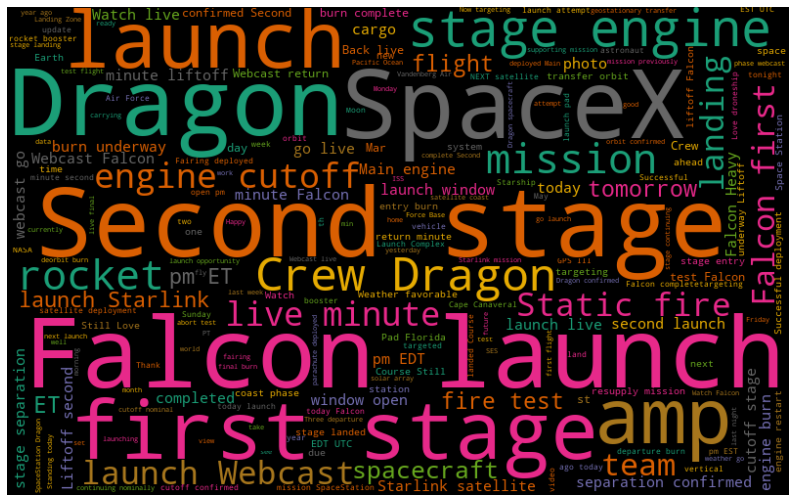

In [ ]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    
all_words = ' '.join([text for text in tweets_df['absolute_tidy_tweets']])
generate_wordcloud(all_words)

In [ ]:
class RetweetParser():
    
    def __init__(self,data,user):
        self.user = user

        edge_list = []
    
        for idx,row in data.iterrows():
            if len(row[4]) > 5:    
                user_account = user
                weight = np.log(row[5] + 1)
                #สร้างความสัมพันธ์จากการถูกtagจากuserที่ค้นหา
                for idx_1, item in enumerate(ast.literal_eval(row[4])):
                    edge_list.append((user_account,item['screen_name'],weight))

                    #สร้างความสัมพันธ์จากการถูกtagในtweetเดียวกัน
                    for idx_2 in range(idx_1+1,len(ast.literal_eval(row[4]))):
                        name_a = ast.literal_eval(row[4])[idx_1]['screen_name']
                        name_b = ast.literal_eval(row[4])[idx_2]['screen_name']

                        edge_list.append((name_a,name_b,weight))
        
        with open(f'{self.user}.csv', 'w', newline='') as csvfile:
            fieldnames = ['user_a', 'user_b', 'log_retweet']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()

            for row in edge_list:        
                writer.writerow({
                                'user_a': row[0],
                                'user_b': row[1],
                                'log_retweet': row[2]
                                })             

In [ ]:
#SpaceX_tweets=pd.read_csv('/content/SpaceX_tweets.csv')
r = RetweetParser(SpaceX_tweets,'SpaceX')

In [ ]:
class TweetGraph():
  
    def __init__(self,edge_list):
        data = pd.read_csv(edge_list).to_records(index=False)
        self.graph = igraph.Graph.TupleList(data, weights=True, directed=False)
        
    def e_centrality(self):
        vectors = self.graph.eigenvector_centrality()
        e = {name:cen for cen, name in  zip([v for v in vectors],self.graph.vs['name'])}
        return sorted(e.items(), key=operator.itemgetter(1),reverse=True)

In [ ]:
m_graph = TweetGraph(edge_list='SpaceX.csv')
m_graph.e_centrality()

[('SpaceX', 1.0),
 ('Space_Station', 0.46097055485853394),
 ('NASA', 0.43510508245054996),
 ('elonmusk', 0.2965434107858547),
 ('Commercial_Crew', 0.08937570626359001),
 ('AstroBehnken', 0.06757072746702986),
 ('Astro_Doug', 0.05966392078298449),
 ('IridiumComm', 0.03385525514424971),
 ('SpaceXJobs', 0.02643554655526142),
 ('NASAKennedy', 0.02253626387865216),
 ('JimBridenstine', 0.020418480387807796),
 ('NASA_Johnson', 0.017455510998452776),
 ('Hyperloop', 0.017396920319958778),
 ('NASA_Astronauts', 0.014627017939044171),
 ('ISS_Research', 0.014117052320627438),
 ('astro_reid', 0.011200075135374644),
 ('AstroDrewMorgan', 0.009322391484839099),
 ('OrbitalSciences', 0.00882559067419474),
 ('MarsCuriosity', 0.008191218456400647),
 ('NASA_TESS', 0.007344828638531272),
 ('SES_Satellites', 0.007202092153525611),
 ('Astro_Jessica', 0.007188676438470052),
 ('BigelowSpace', 0.007164398596756679),
 ('Cmdr_Hadfield', 0.006966655239630215),
 ('Eutelsat_SA', 0.006949984837430323),
 ('SpaceForceDoD

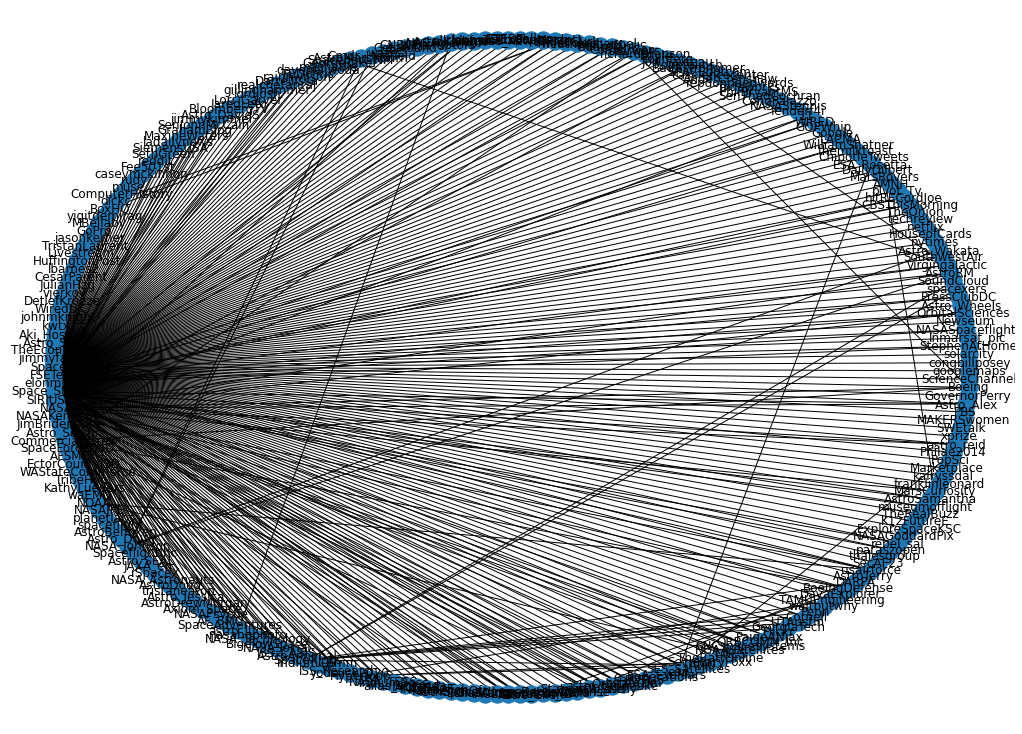

In [ ]:
import networkx as nx
G = nx.Graph()
df=pd.read_csv('/content/SpaceX.csv')
df1 = df[['user_a', 'user_b']]
G = nx.from_pandas_edgelist(df1, 'user_a', 'user_b')
from matplotlib.pyplot import figure
figure(figsize=(14, 10))
nx.draw_shell(G, with_labels=True)

In [ ]:
leaderboard = {}
for x in G.nodes:
 leaderboard[x] = len(G[x])
s = pd.Series(leaderboard, name='connections')
df2 = s.to_frame().sort_values('connections', ascending=False)

In [ ]:
df2

,connections
SpaceX,249
elonmusk,42
NASA,42
Space_Station,34
Commercial_Crew,15
...,...
casciencecenter,1
AnderCrenshaw,1
repdonnaedwards,1
DeptofDefense,1


In [ ]:
A=nx.adjacency_matrix(G).todense()
A

matrix([[1, 1, 1, ..., 1, 1, 1],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 1, 1],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0]], dtype=int64)

In [ ]:
d=np.array(list(dict(G.degree()).values()))

In [ ]:
d

array([250,   1,  43,  35,   1,  43,   7,   4,   1,  16,   2,   2,   1,
         2,   2,   2,   1,   5,   2,   1,   1,  10,   8,  10,   1,   4,
         6,   1,   6,   2,   1,   4,   5,   1,   2,   1,   1,   5,   2,
         2,   3,   1,   4,   1,  11,   1,   1,   7,   2,   4,   1,   2,
         1,   1,   1,   1,   2,   2,   3,   1,   2,   1,   4,   4,   2,
         2,   1,   1,   1,   4,   3,   2,   4,   2,   2,   2,   3,   4,
         2,   7,   3,   1,   3,   2,   4,   1,   2,   2,   2,   5,   5,
         5,   1,   2,   1,   4,   2,   2,   5,   2,   1,   3,   3,   2,
         1,   1,   1,   2,   2,   3,   3,   3,   3,   1,   2,   4,   1,
         1,   2,   2,   4,   1,   4,   1,   1,   1,   1,   2,   1,   2,
         1,   3,   1,   2,   3,   3,   4,   4,   1,   3,   1,   2,   2,
         1,   1,   2,   3,   2,   1,   2,   1,   2,   2,   2,   2,   2,
         2,   1,   2,   2,   1,   5,   5,   5,   5,   5,   1,   1,   1,
         1,   1,   2,   1,   1,   1,   3,   3,   1,   2,   3,   

In [ ]:
D=np.zeros_like(A)

In [ ]:
np.fill_diagonal(D,d)
D

matrix([[250,   0,   0, ...,   0,   0,   0],
        [  0,   1,   0, ...,   0,   0,   0],
        [  0,   0,  43, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   2,   0,   0],
        [  0,   0,   0, ...,   0,   2,   0],
        [  0,   0,   0, ...,   0,   0,   2]], dtype=int64)

In [ ]:
L=D-A
L

matrix([[249,  -1,  -1, ...,  -1,  -1,  -1],
        [ -1,   1,   0, ...,   0,   0,   0],
        [ -1,   0,  42, ...,   0,  -1,  -1],
        ...,
        [ -1,   0,   0, ...,   2,   0,   0],
        [ -1,   0,  -1, ...,   0,   2,   0],
        [ -1,   0,  -1, ...,   0,   0,   2]], dtype=int64)

In [ ]:
val,vec=np.linalg.eig(L)
val

array([2.49996081e+02+0.00000000e+00j, 4.22962755e+01+0.00000000e+00j,
       4.37658977e+01+0.00000000e+00j, 3.48253419e+01+0.00000000e+00j,
       1.58908077e+01+0.00000000e+00j, 1.19127766e+01+0.00000000e+00j,
       1.14016546e+01+0.00000000e+00j, 1.04221372e+01+0.00000000e+00j,
       8.36772608e+00+0.00000000e+00j, 7.95102103e+00+0.00000000e+00j,
       7.26232034e+00+0.00000000e+00j, 2.20258061e-02+0.00000000e+00j,
       6.37882638e+00+0.00000000e+00j, 6.35388818e+00+0.00000000e+00j,
       6.36109136e+00+0.00000000e+00j, 5.66150786e+00+0.00000000e+00j,
       5.45973532e+00+0.00000000e+00j, 1.07760255e+00+0.00000000e+00j,
       1.02084944e+00+0.00000000e+00j, 6.00000000e+00+0.00000000e+00j,
       4.22770092e+00+0.00000000e+00j, 3.69322482e+00+0.00000000e+00j,
       4.56601496e+00+0.00000000e+00j, 4.87629542e+00+0.00000000e+00j,
       4.81893013e+00+0.00000000e+00j, 5.17008649e+00+0.00000000e+00j,
       4.85157546e+00+0.00000000e+00j, 4.60848295e+00+0.00000000e+00j,
      

In [ ]:
v=vec[:,58].real

In [ ]:
v.T.A1

array([-3.54317540e-07,  3.28543171e-07, -1.77721049e-07, -6.47021893e-06,
        3.28543171e-07, -1.26777464e-04,  4.67246691e-05, -1.08076137e-04,
        3.28543171e-07,  3.27052310e-05,  3.28543171e-07,  3.28543171e-07,
        3.28543171e-07,  3.28543171e-07,  3.28543171e-07,  1.62053548e-03,
        3.28543171e-07, -1.84859527e-05,  2.40154949e-04,  3.28543171e-07,
        3.28543171e-07,  1.74190533e-04,  1.52941069e-04,  7.85807403e-04,
        3.28543171e-07,  2.26874907e-04,  2.68585373e-04,  3.28543171e-07,
       -7.40716503e-05,  8.69916504e-05,  3.28543171e-07, -1.67916028e-04,
       -1.89056964e-04,  3.28543171e-07,  1.62053548e-03,  3.28543171e-07,
        3.28543171e-07, -2.50821255e-04, -4.12373700e-04,  1.62053548e-03,
       -1.44975388e-04,  3.28543171e-07, -1.11943375e-04,  3.28543171e-07,
       -1.67160026e-02,  3.28543171e-07,  3.28543171e-07, -8.15027385e-05,
        6.78184008e-06, -4.18448021e-02,  3.28543171e-07,  8.69916504e-05,
        3.28543171e-07,  

In [ ]:
from sklearn.cluster import KMeans
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

    # A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(v.T.A1.reshape(-1,1))
    sse.append(kmeans.inertia_)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  del sys.path[0]


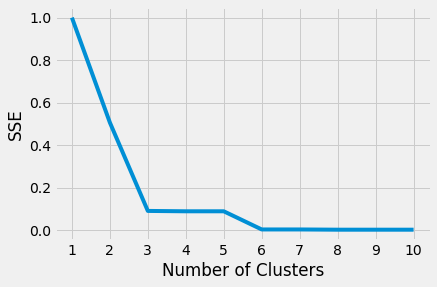

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
km=KMeans(n_clusters=2).fit(v.T.A1.reshape(-1,1))

In [ ]:
km.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
df3 = pd.DataFrame(data={'name':df2.index,'connections':df2.connections,'label':km.labels_})
df3.head(10)

,name,connections,label
SpaceX,SpaceX,249,0
elonmusk,elonmusk,42,0
NASA,NASA,42,0
Space_Station,Space_Station,34,0
Commercial_Crew,Commercial_Crew,15,0
SpaceXJobs,SpaceXJobs,11,0
NASA_Johnson,NASA_Johnson,10,0
AstroBehnken,AstroBehnken,10,0
Astro_Doug,Astro_Doug,8,0
TAMU,TAMU,7,0


In [ ]:
df3.groupby(['label']).get_group(0) 

,name,connections,label
SpaceX,SpaceX,249,0
elonmusk,elonmusk,42,0
NASA,NASA,42,0
Space_Station,Space_Station,34,0
Commercial_Crew,Commercial_Crew,15,0
...,...,...,...
casciencecenter,casciencecenter,1,0
AnderCrenshaw,AnderCrenshaw,1,0
repdonnaedwards,repdonnaedwards,1,0
DeptofDefense,DeptofDefense,1,0


In [ ]:
df3.groupby(['label']).get_group(1) 

,name,connections,label
45thSpaceWing,45thSpaceWing,3,1
richardbranson,richardbranson,3,1
rainnwilson,rainnwilson,2,1
Astro_DavidS,Astro_DavidS,2,1
TEDchris,TEDchris,2,1
